# Regulated Enzymes    
The proteins that are of particular interest from a dynamic simulation perspective are those that regulate fluxes. Regulatory enzymes bind to many ligands. Their functional states can be described in a similar fashion as demonstrated for hemoglobin in the previous chapter. Their states and functions can thus be readily integrated into MASS models. In this chapter we detail the molecular mechanisms for a key regulatory enzyme in glycolysis, _phosphofructokinase_. First we describe the enzyme, then detail the module, or subnetwork, that it represents, and finally integrate them into the metabolic model. We then simulate the altered dynamic network states that result from these regulatory interactions. 

**MASSpy** will be used to demonstrate some of the topics in this chapter.

In [1]:
from mass import (
    MassModel, MassMetabolite, MassReaction,
    Simulation, MassSolution)
from mass.example_data import create_example_model
from mass.util.expressions import Keq2k, k2Keq, strip_time
from mass.util.matrix import nullspace, left_nullspace, matrix_rank
from mass.visualization import (
    plot_time_profile, plot_phase_portrait, plot_tiled_phase_portraits,
    plot_comparison)

Other useful packages are also imported at this time.

In [2]:
from os import path

from cobra import DictList
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sympy as sym

Some options and variables used throughout the notebook are also declared here.

In [3]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.3f}'.format
S_FONT = {"size": "small"}
L_FONT = {"size": "large"}
INF = float("inf")

## Phosphofructokinase
Phosphofructokinase (PFK) is a tetrameric enzyme. There are isoforms of the subunits of the enzyme, meaning that there is more than one gene for each subunit and the genes are not identical. The isoforms are differentially expressed in various tissues, and therefore different versions of the enzyme are active in different tissues. The regulation of PFK is quite complicated [Okar01]. Here, for illustrative purposes, we will consider a homotetrameric form of PFK, Figure 14.1 with one activator (AMP) and one inhibitor (ATP). 

![Figure-14-1](../images/Ch14/Figure-14-1.png)

**Figure 14.1:** The phosphofructokinase, PFK, subnetwork; the reaction schema for catalysis, for regulation, and the exchanges with the rest of the metabolic network. The numerical values of the dissociation constants are taken from [Joshi 1990]; $K_{ATP}$ is 0.068 mM, $K_{F6P}$ is 0.1 mM, $K_{a}$ is 0.33 mM and $K_{i}$ is 0.01 mM. The $K_{i}$ binding constant for ATP as an inhibitor is increased by a factor of ten since magnesium complexing of ATP is not considered here. The allosteric constant $L$ is 0.0011.

### The reaction catalyzed  
PFK is a major regulatory enzyme in glycolysis. It catalyzes the reaction 

$$\begin{equation} \text{F6P} + \text{ATP} \stackrel{\text{PFK}}{\rightarrow} \text{FDP} + \text{ADP} + \text{H} \tag{14.1} \end{equation}$$

In Chapter 10 we introduced this reaction as a part of the glycolytic pathway. 

### The subnetwork  
The detailed reaction mechanism of PFK is shown in Figure 14.1. The reactants, F6P and ATP, and products, FDP and ADP, enter and leave the subnetwork. These exchanges will reach a steady state. The regulators, AMP is an activator and ATP is an inhibitor, also enter and leave the subnetwork. They reach an equilibrium in the steady state, as they have no flow through the subnetwork. The bound states of PFK thus equilibrate with its regulators while the reactants and products will flow through the subnetwork. 

### Placing the PFK subnetwork into a known network environment  
We will first analyze the PFK subnetwork by itself.  To do so, we have to add exchange reactions from the network environment.  The numerical values for the concentrations external to the PFK subnetwork have to be added.  We can then explore the properties of this subnetwork model by itself. 

First we establish the PFK subnetwork:

In [4]:
PFK = create_example_model("SB2_PFK")

Then we place the PFK subnetwork into its network context:

In [5]:
for met in ["f6p_c", "fdp_c", "amp_c", "adp_c", "atp_c", "h_c"]:
    PFK.add_boundary(met, boundary_type="sink", boundary_condition=1);
PFK

Name,PFK
Memory address,0x07ff5d375bb90
Stoichiometric Matrix,26x30
Matrix Rank,25
Subsystem,Glycolysis
Number of ligands,6
Number of enzyme module forms,20
Initial conditions defined,26/26
Number of enzyme module reactions,24
Total enzyme concentration,3.3e-05
Enzyme rate,1.12


In [6]:
new_metabolite_order = ['f6p_c', 'fdp_c', 'amp_c', 'adp_c', 'atp_c', 'h_c',
                        'pfk_R0_c', 'pfk_R0_A_c', 'pfk_R0_AF_c', 
                        'pfk_R1_c', 'pfk_R1_A_c', 'pfk_R1_AF_c', 
                        'pfk_R2_c', 'pfk_R2_A_c', 'pfk_R2_AF_c', 
                        'pfk_R3_c', 'pfk_R3_A_c', 'pfk_R3_AF_c',
                        'pfk_R4_c', 'pfk_R4_A_c', 'pfk_R4_AF_c',  
                        'pfk_T0_c','pfk_T1_c', 'pfk_T2_c', 'pfk_T3_c', 'pfk_T4_c']

if len(PFK.metabolites) == len(new_metabolite_order):
    PFK.metabolites = DictList(PFK.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = ["SK_f6p_c", "SK_fdp_c", "SK_amp_c", 
                      "SK_adp_c", "SK_atp_c", "SK_h_c", 
                      "PFK_R01", "PFK_R02", "PFK_R03",
                      "PFK_R10", "PFK_R11", "PFK_R12", "PFK_R13",
                      "PFK_R20", "PFK_R21", "PFK_R22", "PFK_R23", 
                      "PFK_R30", "PFK_R31", "PFK_R32", "PFK_R33",
                      "PFK_R40", "PFK_R41", "PFK_R42", "PFK_R43", 
                      "PFK_L", "PFK_T1", "PFK_T2", "PFK_T3", "PFK_T4"]

if len(PFK.reactions) == len(new_reaction_order):
    PFK.reactions = DictList(PFK.reactions.get_by_any(new_reaction_order))
PFK.update_S(array_type="DataFrame");

,SK_f6p_c,SK_fdp_c,SK_amp_c,SK_adp_c,SK_atp_c,SK_h_c,PFK_R01,PFK_R02,PFK_R03,PFK_R10,PFK_R11,PFK_R12,PFK_R13,PFK_R20,PFK_R21,PFK_R22,PFK_R23,PFK_R30,PFK_R31,PFK_R32,PFK_R33,PFK_R40,PFK_R41,PFK_R42,PFK_R43,PFK_L,PFK_T1,PFK_T2,PFK_T3,PFK_T4
f6p_c,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000
fdp_c,0.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
amp_c,0.000,0.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
adp_c,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
atp_c,0.000,0.000,0.000,0.000,-1.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,-1.000,-1.000,-1.000,-1.000
h_c,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
pfk_R0_c,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.000
pfk_R0_A_c,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
pfk_R0_AF_c,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
pfk_R1_c,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


With these additions we can re-examine the properties of this model of the PFK subnetwork.

### Bound states of PFK  
The enzyme exists in two natural forms, T, or tight, and R, or relaxed, recall Section 5.5. 

$$\begin{equation} R_0 \leftrightharpoons T_0 \tag{14.2} \end{equation}$$

The R form is catalytically active and the T form is inactive. The two forms are in equilibrium as 

$$\begin{equation} L = \frac{T_0}{R_0} = 0.0011 \tag{14.3} \end{equation}$$

where $L$ is the allosteric constant for PFK. 

There are many ligands that can bind to PFK to modulate its activity by altering the balance of the T and R forms. Here we will consider AMP as an activator and ATP as an inhibitor. AMP will bind to the R state; 

$$\begin{align} R_0 + \text{AMP} &\leftrightharpoons R_1 \tag{14.4} \\ \\ R_1 + \text{AMP} &\leftrightharpoons R_2 \tag{14.5} \\ \\ R_2 + \text{AMP} &\leftrightharpoons R_3 \tag{14.6} \\ \\ R_3 + \text{AMP} &\leftrightharpoons R_4 \tag{14.7} \\ \end{align}$$

and ATP will bind to the T state: 

$$\begin{align} T_0 + \text{ATP} \leftrightharpoons T_1 \tag{14.8} \\ \\ T_1 + \text{ATP} \leftrightharpoons T_2 \tag{14.9} \\ \\ T_2 + \text{ATP} \leftrightharpoons T_3 \tag{14.10}\\ \\ T_3 + \text{ATP} \leftrightharpoons T_4 \tag{14.11}\\ \\ \end{align}$$

The chemical reaction, see Eq. (14.1), will proceed in three steps: 

$\textbf{1.}$ the binding of the cofactor ATP 

$$\begin{equation} \stackrel{\text{substrate in}}{\longrightarrow} \text{ATP} + R_i \leftrightharpoons R_{i, A} \tag{14.12} \end{equation}$$

$\textbf{2.}$ the binding of the substrate F6P 

$$\begin{equation} \stackrel{\text{substrate in}}{\longrightarrow} \text{F6P} + R_{i, A} \leftrightharpoons R_{i, AF} \tag{14.13} \end{equation}$$

$\textbf{3.}$the catalytic conversion to the products 

$$\begin{equation} R_{i, AF} \stackrel{\text{transformation}}{\longrightarrow} R_{i} + \text{FDP} + \text{ADP} + \text{H} \stackrel{\text{products out}}{\longrightarrow} \end{equation}$$

$\textbf{4.}$ and the release of the enzyme. 

The subscript $i\ (i=0,1,2,3,4)$ indicates how many activator molecules (AMP) are bound to the R from of the enzyme. The free from $(i=0)$ and all the bound forms are catalytically active. 

![Figure-14-2](../images/Ch14/Figure-14-2.png)

**Figure 14.2:** Pictorial representation of the PFK subnetwork. The inactive tight $(T_i)$ states are designated with a square, and the substrate binding sites, designated with an open circle, are not accessible. The shading of the sub-squares indicate that the inhibitor (ATP) occupies that site. The active relaxed form $(R_i)$ are shown with a circle, where the binding sites for the activator (AMP) are indicated. Shading means that the AMP binding site is occupied. The semi-circle below the circle shows that the binding sites are now on the surface of the protein and can now be occupied by the reactants (ATP and F6P). The $(R_{i, AF})$ state catalyzes the reaction.

A pictorial representation of the PKF subnetwork is shown in FIgure 14.2, and a MASS model of the PFK subnetwork is shown below:

### The elemental matrix
The elemental composition of the compounds in the PFK subnetwork are shown in Table 14.1. The low molecular weight compounds are detailed in terms of their elemental composition while the enzyme itself is treated as one moiety. It never leaves the system and is never chemically modified, so we can treat it as one entity. 

**Table 14.1:** The elemental composition of the compounds in the PFK subnetwork. The PFK protein molecule is treated as one moiety.

In [7]:
table_14_1 = PFK.get_elemental_matrix(array_type="DataFrame",
                                      dtype=np.int64)
table_14_1

,f6p_c,fdp_c,amp_c,adp_c,atp_c,h_c,pfk_R0_c,pfk_R0_A_c,pfk_R0_AF_c,pfk_R1_c,pfk_R1_A_c,pfk_R1_AF_c,pfk_R2_c,pfk_R2_A_c,pfk_R2_AF_c,pfk_R3_c,pfk_R3_A_c,pfk_R3_AF_c,pfk_R4_c,pfk_R4_A_c,pfk_R4_AF_c,pfk_T0_c,pfk_T1_c,pfk_T2_c,pfk_T3_c,pfk_T4_c
C,6,6,10,10,10,0,0,10,16,10,20,26,20,30,36,30,40,46,40,50,56,0,10,20,30,40
H,11,10,12,12,12,1,0,12,23,12,24,35,24,36,47,36,48,59,48,60,71,0,12,24,36,48
O,9,12,7,10,13,0,0,13,22,7,20,29,14,27,36,21,34,43,28,41,50,0,13,26,39,52
P,1,2,1,2,3,0,0,3,4,1,4,5,2,5,6,3,6,7,4,7,8,0,3,6,9,12
N,0,0,5,5,5,0,0,5,5,5,10,10,10,15,15,15,20,20,20,25,25,0,5,10,15,20
S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
q,-2,-4,-2,-3,-4,1,0,-4,-6,-2,-6,-8,-4,-8,-10,-6,-10,-12,-8,-12,-14,0,-4,-8,-12,-16
[PFK],0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### The stoichiometric matrix  
The reactions that correspond to this subnetwork of binding states and catalytic conversions can be summarized in a stoichiometric matrix, shown in Table 14.2. This matrix is 26 x 30 of rank 25. 

**Table 14.2:** The stoichiometric matrix for the PFK subnetwork.  The last eight columns are the exchange rates (orange), the connectivity numbers (red), and the time invariant pool (lime green). The next set of columns (yellow) are the PFK reaction itself (five sets, one for each $R_i, i = (0, 1, 2, 3, 4)$. The next five columns (green) are conversion into the T form and the binding reactions for the inhibitor. The first six rows (orange) are the compounds participating in the reaction, then the relaxed states of the enzyme (yellow), then the tense states of the enzyme (green), then the participation number(cyan), then the elemental balancing of the reactions (blue), and finally the pathway vectors (purple).

In [8]:
metabolite_ids = [m.id for m in PFK.metabolites]
reaction_ids = [r.id for r in PFK.reactions]
# Define labels
pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', '[PFK]']
path_labels = ["$p_1$", "$p_2$", "$p_3$", "$p_4$", "$p_5$"]
time_inv_labels = ["PFK-Total"]

ns = np.zeros((5, 30))
for i in range(5):
    ns[i][i*3:i*3+3] = 1
lns = np.zeros((1, 26))
lns[0][6:] = 1


# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = PFK.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = PFK.get_elemental_charge_balancing()
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
table_14_2 = np.vstack((S_matrix, pi, ES_matrix, ns))
# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_14_2) - len(PFK.metabolites))
rho = np.concatenate((rho, blanks))
time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_14_2 = np.vstack([table_14_2.T, rho, time_inv]).T

colors = {"relaxed": "#ffffe6",       # Yellow
          "tight": "#d9fad2",         # Green
          "exchanges": "#ffe6cc",     # Orange
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Lime Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
def highlight_table(df, model):
    df = df.copy()
    n_mets, n_rxns = (len(model.metabolites), len(model.reactions))
    # Highlight rows
    for row in df.index:
        other_key, condition = ("blank", lambda i, v: v != "")
        if row == pi_str:        # For participation
            main_key = "pi"
        elif row in chopsnq:     # For elemental balancing
            main_key = "chopsnq"
        elif row in path_labels: # For pathways
            main_key = "pathways"
        elif "pfk" not in row:
            main_key = "exchanges"
        elif "pfk_T" in row:
            main_key, other_key = ("exchanges", "tight")
            condition = lambda i, v: (i < len(model.boundary) and i < n_rxns)
        else:
            main_key, other_key = ("exchanges", "relaxed")            
            condition = lambda i, v: (i < len(model.boundary) and i < n_rxns)

        df.loc[row, :] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else bg_color_str + colors[other_key] 
                          for i, v in enumerate(df.loc[row, :])]

    for col in df.columns:
        condition = lambda i, v: v != bg_color_str + colors["blank"]
        if col == rho_str:
            main_key = "rho"
        elif col in time_inv_labels:
            main_key = "time_invs"
        elif "PFK_T" in col or "PFK_L" in col:
            main_key = "tight"
            condition = lambda i, v: (5 < i < n_mets)
        else:
            main_key = "exchanges"
            condition = lambda i, v: (i < n_mets - 20)
        df.loc[:, col] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else v for i, v in enumerate(df.loc[:, col])]
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_14_2 = pd.DataFrame(
    table_14_2, index=index_labels, columns=column_labels)
# Apply colors
table_14_2 = table_14_2.style.apply(
    highlight_table,  model=PFK, axis=None)
table_14_2

,SK_f6p_c,SK_fdp_c,SK_amp_c,SK_adp_c,SK_atp_c,SK_h_c,PFK_R01,PFK_R02,PFK_R03,PFK_R10,PFK_R11,PFK_R12,PFK_R13,PFK_R20,PFK_R21,PFK_R22,PFK_R23,PFK_R30,PFK_R31,PFK_R32,PFK_R33,PFK_R40,PFK_R41,PFK_R42,PFK_R43,PFK_L,PFK_T1,PFK_T2,PFK_T3,PFK_T4,$\rho_{i}$,PFK-Total
f6p_c,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0
fdp_c,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,0.0
amp_c,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0
adp_c,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,0.0
atp_c,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,10,0.0
h_c,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,0.0
pfk_R0_c,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4,1.0
pfk_R0_A_c,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0
pfk_R0_AF_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0
pfk_R1_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0


### The null spaces of the stoichiometric matrix  

The null space is 5 (=30-25) dimensional. The five pathway vectors spanning the null space are simply the input of the reagents, the PFK reaction itself and the output of the products, see Table 14.2. Each pathway is catalyzed by one of the five active R forms. Thus these form 5 parallel pathways through the subnetwork where the flux through each is determined by the relative amount of the R forms of the enzyme. 

The left null space is one dimensional (=26-25). It is spanned by a vector that represents the conservation of the PFK enzyme itself, see Table 14.2

### Pools and ratios
The enzyme is in two key states, the relaxed (R) and the tight (T) state. The binding of the activator, AMP, pulls the enzyme towards the catalytically active relaxed state while binding of the the inhibitor, ATP, pulls it towards the catalytically inactive tight state, creating a tug of war over the catalytic capacity of the enzyme. The fraction of the total enzyme that is in the R form can be computed: 

$$\begin{equation} r_\mathrm{R} = \frac{\Sigma_{i=0}^{4}(R_i + R_{i, A} + R_{i, AF})}{\text{PFK}_{\mathrm{tot}}} \tag{14.15} \end{equation}$$

The relaxed states are then pooled into the form that is loaded with substrates that carry out the reaction. We thus define the fraction of the enzyme R states that is loaded with the substrates and is producing the product as; 

$$\begin{equation} r_\mathrm{cat} = \frac{\Sigma_{i=0}^{4}R_{i, AF}}{\Sigma_{i=0}^{4}(R_i + R_{i, A} + R_{i, AF})} \tag{14.16} \end{equation}$$

This fraction of the enzyme generates the products. 

## The Steady State  
### The reaction rate  
The steady state flux through the PFK subnetwork is given by 

$$\begin{align} v_{PFK} &= k_{PFK} \Sigma_{i=0}^{4}R_{i, AF} \tag{14.17} \\ &= k_{PFK}\text{PFK}_{\mathrm{tot}}r_\mathrm{R}r_\mathrm{cat} \tag{14.18} \\ \end{align}$$

In this equation we know the steady state flux and the total amount of enzyme. We will use the glycolytic flux in Chapter 10 of 1.12 mM/hr. The concentration of PFK in the RBC is about 0.000033 mM (Albe 1990).

### Integration of the PFK subnetwork into the metabolic network  
We can compute $r_\mathrm{R}$ and $r_\mathrm{cat}$ from equilibrium binding of the regulatory ligands to PFK. We know the steady state concentrations of these ligands in the network; ATP is about 1.6 mM and AMP is about 0.087 mM. We also know the steady state concentration of the reactants ATP and F6P, the latter is about 0.02 mM. The algebra associated with these computations is quite intricate, albeit simple in principle. Its complexity was foreshadowed in Chapter 5. 

Once we have computed the PERC, $k_{PFK}$, we can integrate the PFK subnetwork into the glycolytic model. Such integration procedures can be performed for any enzyme of interest in a given network. 

### Solving for the steady state  
The steady state equations are 

$$\begin{equation} \textbf{Sv(x)} = 0 \tag{14.19} \end{equation}$$

The elementary forms of the rate laws 
$$\begin{align} &v_{R_{0, 1}} : k^+_AR_{0} &&- k^-_AR_{0, A} \\ &v_{R_{0, 2}} : k^+_FR_{0,A} &&- k^-_FR_{0, AF} \\ &v_{R_{0, 3}} : k_{PFK}R_{0, AF} && \\ &v_{R_{1, 0}} : 4k^+_{a}R_{0} &&- k^-_{a}R_{1} \\ &v_{R_{1, 1}} : k^+_AR_{1} &&- k^-_AR_{1, A} \\ &v_{R_{1, 2}} : k^+_FR_{1,A} &&- k^-_FR_{1, AF} \\ &v_{R_{1, 3}} : k_{PFK}R_{1, AF} && \\ &v_{R_{2, 0}} : 3k^+_{a}R_{1} &&- 2k^-_{a}R_{2} \\ &v_{R_{2, 1}} : k^+_AR_{2} &&- k^-_AR_{2, A} \\ &v_{R_{2, 2}} : k^+_FR_{2,A} &&- k^-_FR_{2, AF} \\ &v_{R_{2, 3}} : k_{PFK}R_{2, AF} && \\ &v_{R_{3, 0}} : 2k^+_{a}R_{2} &&- 3k^-_{a}R_{3} \\ &v_{R_{3, 1}} : k^+_AR_{3} &&- k^-_AR_{3, A} \\ &v_{R_{3, 2}} : k^+_FR_{3,A} &&- k^-_FR_{3, AF} \\ &v_{R_{3, 3}} : k_{PFK}R_{3, AF} && \\ &v_{R_{4, 0}} : k^+_{a}R_{3} &&- 4k^-_{a}R_{4} \\ &v_{R_{4, 1}} : k^+_AR_{4} &&- k^-_AR_{4, A} \\ &v_{R_{4, 2}} : k^+_FR_{4,A} &&- k^-_FR_{4, AF} \\ &v_{R_{4, 3}} : k_{PFK}R_{4, AF} && \\ &v_{L} : k^+R_{0} &&- k^-T_{0} \\ &v_{T_{1}} : 4k^+_{i}T_{0} &&- k^-_{i}T_{1} \\ &v_{T_{2}} : 3k^+_{i}T_{1} &&- 2k^-_{i}T_{2} \\ &v_{T_{3}} : 2k^+_{i}T_{2} &&- 3k^-_{i}T_{3} \\ &v_{T_{4}} : k^+_{i}T_{3} &&- 4k^-_{i}T_{4} \\ \end{align}$$ $$\tag{14.20}$$

can be introduced into this equation to form 19 algebraic equations in 20 concentration variables as unknowns, where 

$$\begin{equation} L = \frac{k^+}{k^-},\ K_i = \frac{k^+_i}{k^-_i},\ K_a = \frac{k^+_a}{k^-_a},\ K_F = \frac{k^+_F}{k^-_F},\ K_A = \frac{k^+_A}{k^-_A} \tag{14.21} \end{equation}$$

and where the forward rate constants ${k^+_F}$, ${k^+_A}$, ${k^+_a}$, and ${k^+_i}$ contain the steady state concentrations of the corresponding ligand. This makes all the rate laws linear. 

The total mass balance on all the forms of the enzyme 

$$\begin{equation} \text{PFK}_{\mathrm{tot}} = \underset{i=0}{\stackrel{4}{\sum}}(R_i + R_{i, A} + R_{i, AF}) + \underset{i=0}{\stackrel{4}{\sum}} T_{i} \tag{14.22} \end{equation}$$

will lead to 20 algebraic equations with 20 concentration variables. 

In addition, the reaction rate $v_{PFK}$ is the input flux for the reactants and the output flux for the product in the steady state. The reaction rate is: 

$$\begin{equation} v_{PFK} = k_{PFK} \underset{i=0}{\stackrel{4}{\sum}}R_{i, AF} \tag{14.23} \end{equation}$$

where $k_{PFK}$ is unknown. Since the binding step of the activator and the inhibitor is at equilibrium at steady state only the corresponding equilibrium constants will appear in the steady state equation. However, since the binding of the reactants are in a steady state we will need numerical values for $k^-_F$ and $k^-_A$. 

In principle, we can thus specify $k^-_F$ and $k^-_A$ and solve 20 equations for the 20 concentration variables and $k_{PFK}$, given numerical values for the total amount of enzyme and the 5 binding constants in Eq. (14.21). In practice, the choices for $k^-_F$ and $k^-_A$ are restricted for the computed concentrations and $k_{PFK}$ to take on positive values. 

### The steady state solution  
The solution to the 19 algebraic equations with the reaction rate law (Eq. (14.23)) is given in Table 14.3. The total PFK can then be computed from Eq. (14.22).

First, we will remove the ligands from the equations by substituting them for a value of 1 to account for the forward rate consants including the steady state concentrations of their corresponding ligands. Next, we will identify the enzyme forms and store them in a list. Finally, we define a dictionary of the ordinary differential equations as sympy expressions with the ligand concentrations lumped into the rate constants.

In [9]:
n_sites = 4
n_binding_steps = 3

enzyme_forms = [sym.Symbol(met.id) for met in PFK.metabolites
                if "pfk" in met.id]
conc_subs = {sym.Symbol(met.id): 1 for met in PFK.metabolites
             if "pfk" not in met.id}

ode_dict = {sym.Symbol(met.id): sym.Eq(ode.subs(conc_subs), 0)
            for met, ode in Keq2k(strip_time(PFK.odes)).items()
            if "pfk" in met.id}

We then identify equations for the unknown concentrations we wish to solve for in each reaction. We will treat the completely free form of the enzyme with no activators or inhibitors as our dependent variable.

In [10]:
enzyme_forms.reverse()

pfk_solutions = {}
for pfk_form in enzyme_forms:
    if "pfk_R0_c" == str(pfk_form):
        continue
    sol = sym.solveset(ode_dict[pfk_form].subs(pfk_solutions), pfk_form)
    pfk_solutions[pfk_form] = list(sol).pop()
    pfk_solutions.update({pfk_form: sol.subs(pfk_solutions) 
                          for pfk_form, sol in pfk_solutions.items()})

We also determine the catalyzation reactions and isolate them in order to create our equation for $v_{PFK}$.

In [11]:
catalyzation_reactions = ["PFK_R{0:d}{1:d}".format(i, n_binding_steps) 
                          for i in range(n_sites + 1)]
v_PFK_sym = sym.Symbol("v_PFK")
v_PFK_equation = v_PFK_sym - sym.simplify(sum(strip_time([
    PFK.reactions.get_by_id(rxn).rate for rxn in catalyzation_reactions])))
sym.pprint(v_PFK_equation)

-kf_PFK⋅(pfk_R0_AF_c + pfk_R1_AF_c + pfk_R2_AF_c + pfk_R3_AF_c + pfk_R4_AF_c) 
+ v_PFK


We utilize the reaction rate equation and solve for the our final unknown concentration variable in terms of the rate constants. Once it has been solved for, we substitute the solution back into our other equations.

In [12]:
sol = sym.solveset(v_PFK_equation.subs(pfk_solutions), "pfk_R0_c")
pfk_solutions[sym.Symbol("pfk_R0_c")] = list(sol).pop()
pfk_solutions = {met: sym.simplify(solution.subs(pfk_solutions)) 
                 for met, solution in pfk_solutions.items()}

The first column in Table 14.3 shows the solution for $R_{i, 0}$. Summing up these columns gives the total amount of the  $R_{i, 0}$ forms The next three columns show the relative distribution of the  $R_{i, 0}$,  $R_{i, A}$, and $R_{i, AF}$ forms. These relative amounts are the same for all the activator bound states of the enzyme, i.e., the same for all $i$. 

Thus the relative amount of the enzyme in the different activator bound states is given by the relative amount of the $R_{i, 0}$ forms, shown in the fourth column of the table.

The solution for $T_{0}$ is: 

$$\begin{equation} T_0 = \frac{(k_i^-)^4Lv_{PFK}(k_A^-(k_F^- + k_{PFK}) + k_F^+k_{PFK})}{k_A^+k_F^+k_{PFK}(k_i^- + k_i^+)^4} \tag{14.24} \end{equation}$$

and then the relative amount of the $T_{i}$ forms is given in the last column of Table 14.3. 

**Table 14.3:** The steady-state solution for the enzyme concentrations in the PFK sub-network.

In [13]:
table_14_3 = []

R10, T00 = (pfk_solutions[sym.Symbol(k)] for k in ["pfk_R0_AF_c", "pfk_T0_c"])
for i in range(5):
    keys = ("pfk_R{0:d}_c|pfk_R{0:d}_A_c|pfk_R{0:d}_AF_c|pfk_T{0:d}_c"
            .format(i).split("|"))
    Ri0, RiA, RiAF, Ti0 = (pfk_solutions[sym.Symbol(k)] for k in keys)
    num_denom_zip = zip([Ri0, Ri0, RiA, RiAF, RiAF, Ti0], [1, Ri0, Ri0, Ri0, R10, T00])
    ratios = [sym.collect(numerator/denominator, "kf_PFK") for numerator, denominator in num_denom_zip]
    table_14_3.append(["${0}$".format(sym.latex(ratio)) for ratio in ratios])

column_labels = ["$R_{i,0}$", "$R_{i,0} / R_{i,0}$", "$R_{i,A} / R_{i,0}$",
                 "$R_{i,AF} / R_{i,0}$", "$R_{i,0} / R_{0,0}$", "$T_{i} / T_{0}$"]
table_14_3 = pd.DataFrame(
    np.array(table_14_3), columns=column_labels)
                          
table_14_3.index.rename("i", inplace=True);
table_14_3

,"$R_{i,0}$","$R_{i,0} / R_{i,0}$","$R_{i,A} / R_{i,0}$","$R_{i,AF} / R_{i,0}$","$R_{i,0} / R_{0,0}$",$T_{i} / T_{0}$
i,,,,,,
0,$\frac{kr_{PFK ACT}^{4} v_{PFK} \left(kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}\right)}{kf_{PFK} kf_{PFK A} kf_{PFK F} \left(kf_{PFK ACT} + kr_{PFK ACT}\right)^{4}}$,$1$,$\frac{kf_{PFK A} \left(kf_{PFK} + kr_{PFK F}\right)}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{kf_{PFK A} kf_{PFK F}}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$1$,$1$
1,$\frac{4 kf_{PFK ACT} kr_{PFK ACT}^{3} v_{PFK} \left(kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}\right)}{kf_{PFK} kf_{PFK A} kf_{PFK F} \left(kf_{PFK ACT} + kr_{PFK ACT}\right)^{4}}$,$1$,$\frac{kf_{PFK A} \left(kf_{PFK} + kr_{PFK F}\right)}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{kf_{PFK A} kf_{PFK F}}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{4 kf_{PFK ACT}}{kr_{PFK ACT}}$,$\frac{4 kf_{PFK I}}{kr_{PFK I}}$
2,$\frac{6 kf_{PFK ACT}^{2} kr_{PFK ACT}^{2} v_{PFK} \left(kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}\right)}{kf_{PFK} kf_{PFK A} kf_{PFK F} \left(kf_{PFK ACT} + kr_{PFK ACT}\right)^{4}}$,$1$,$\frac{kf_{PFK A} \left(kf_{PFK} + kr_{PFK F}\right)}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{kf_{PFK A} kf_{PFK F}}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{6 kf_{PFK ACT}^{2}}{kr_{PFK ACT}^{2}}$,$\frac{6 kf_{PFK I}^{2}}{kr_{PFK I}^{2}}$
3,$\frac{4 kf_{PFK ACT}^{3} kr_{PFK ACT} v_{PFK} \left(kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}\right)}{kf_{PFK} kf_{PFK A} kf_{PFK F} \left(kf_{PFK ACT} + kr_{PFK ACT}\right)^{4}}$,$1$,$\frac{kf_{PFK A} \left(kf_{PFK} + kr_{PFK F}\right)}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{kf_{PFK A} kf_{PFK F}}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{4 kf_{PFK ACT}^{3}}{kr_{PFK ACT}^{3}}$,$\frac{4 kf_{PFK I}^{3}}{kr_{PFK I}^{3}}$
4,$\frac{kf_{PFK ACT}^{4} v_{PFK} \left(kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}\right)}{kf_{PFK} kf_{PFK A} kf_{PFK F} \left(kf_{PFK ACT} + kr_{PFK ACT}\right)^{4}}$,$1$,$\frac{kf_{PFK A} \left(kf_{PFK} + kr_{PFK F}\right)}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{kf_{PFK A} kf_{PFK F}}{kf_{PFK} \left(kf_{PFK F} + kr_{PFK A}\right) + kr_{PFK A} kr_{PFK F}}$,$\frac{kf_{PFK ACT}^{4}}{kr_{PFK ACT}^{4}}$,$\frac{kf_{PFK I}^{4}}{kr_{PFK I}^{4}}$


### Numerical values  
We now introduce the numerical values, $K_i=0.1/1.6$, $K_a=0.033/0.0867$, $K_A=0.068/1.6$, $K_F=0.1/0.0198$, $v_{PFK}=1.12 \text{mM/hr}$, and $K_L=1/0.0011$ using the dissociation constant values given earlier in the chapter and the steady state concentrations of the ligands. We can introduce these into the solution and sum over all the forms of the enzyme to get 

In [14]:
# Extract steady state values from glycolysis
glycolysis = create_example_model("SB2_Glycolysis")
abbrev_dict = {"PFK_A": "atp_c", "PFK_F": "f6p_c", "PFK_ACT": "amp_c", "PFK_I": "atp_c", "PFK_L": ""}

k2K = {sym.Symbol("kr_" + p): sym.Symbol("kf_" + p)*sym.Symbol("K_" + p) for p in abbrev_dict.keys()}
pfk_solutions = {met: sym.simplify(solution.subs(pfk_solutions).subs(k2K))
                 for met, solution in pfk_solutions.items()}
K_values = dict(zip(["K_" + p for p in abbrev_dict], [0.068, 0.1, 0.033, 0.1, 0.0011]))


numerical_values = {}
for abbrev, ligand_id in abbrev_dict.items():
    K_str = "K_" + abbrev
    if ligand_id:
        ligand = glycolysis.metabolites.get_by_id(ligand_id)
        numerical_value = K_values[K_str]/glycolysis.initial_conditions[ligand]
    else:
        numerical_value = 1/K_values[K_str]
    numerical_values[sym.Symbol(K_str)] = numerical_value
    
pfk_total_sym = sym.Symbol("PFK-Total")
numerical_values.update({
    v_PFK_sym: glycolysis.reactions.PFK.steady_state_flux,
    pfk_total_sym: 0.033e-3})

pfk_total_equation = sym.Eq(pfk_total_sym, sum(enzyme_forms))
pfk_total_equation = sym.simplify(pfk_total_equation.subs(pfk_solutions).subs(numerical_values))
sym.pprint(sym.N(pfk_total_equation, 3))

  1.19       1.71      7.14          
──────── + ──────── + ────── = 3.3e-5
kf_PFK_F   kf_PFK_A   kf_PFK         


$$\begin{equation} \text{PFK}_{\mathrm{tot}} = 1.71/k_A^+ + 1.19/k_F^+ + 7.14/k_{PFK}^= 0.000033 \text{mM} \tag{14.25} \end{equation}$$

The three parameter values are thus not independent as stated above. This equation can be plotted in three dimensions, Figure 14.3. For the simulations below we choose $k_F^+ = 1*10^6 \text{1/h/mM}$ and $k_A^+ = 2*10^5 \text{1/h/mM}$ and compute $k_{PFK}=3.07*10^5 \text{1/h}$ from equation 14.25. With these values about 90% of the enzyme is in the R form $r_\mathrm{R}=0.896)$, and about 12% of R is in the $R_{i, AF}$ forms $(r_\mathrm{cat}=0.123)$. With these values the relative flux load through the five forms of $R_{i, AF}$ is: 

$$\begin{align} &i, \ &\text{fraction} \\ &0, \ &0.00577 \\ &1, \ &0.0607 \\ &2, \ &0.239 \\ &3, \ &0.419 \\ &4, \ &0.275 \\ \end{align}$$ $$\tag{14.26}$$

Thus most of the flux is carried by $R_{3, AF}$ for these parameter values and steady state concentrations of ligands. 

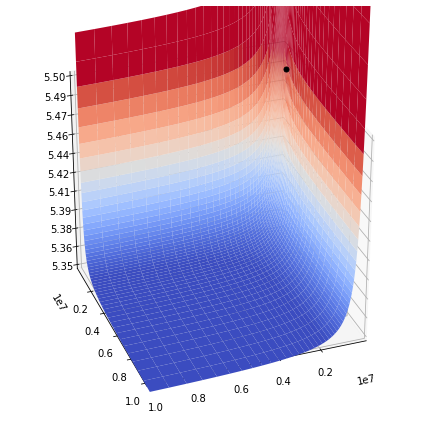

In [15]:
kf_PFK_sym = sym.Symbol("kf_PFK")
kf_PFK_sol = sym.solve([3.3e-05 - pfk_total_equation.lhs], kf_PFK_sym)[kf_PFK_sym]

args = tuple(sym.Symbol(param) for param in sorted(
    str(symbol) for symbol in kf_PFK_sol.atoms(sym.Symbol)))
kf_PFK_sol = sym.lambdify(args, sym.log(kf_PFK_sol, 10), modules="numpy")

fig_14_3 = plt.figure(figsize=(6, 6))
ax = fig_14_3.add_subplot(111, projection="3d")

ka  = np.geomspace(1e5, 1e7, 50)
kf  = np.geomspace(1e5, 1e7, 50)
ka, kf = np.meshgrid(ka, kf)
# Plot the surface.
surf = ax.plot_surface(ka, kf, kf_PFK_sol(ka, kf),
                       linewidth=0, antialiased=True, vmin=5.35, vmax=5.5, 
                       cmap=plt.cm.coolwarm, zorder=0)
ax.view_init(30, 70);
ax.set_xlim(1e4, 1e7);
ax.set_ylim(1e4, 1e7);
ax.set_zlim(5.35, 5.5);
ax.zaxis.set_major_locator(mpl.ticker.LinearLocator());
ax.zaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.02f'));
ax.plot([2e5], [1e6], [kf_PFK_sol(2e5, 1e6)],
        markerfacecolor='k', markeredgecolor='k',
        marker='o', markersize=5, zorder=10);
fig_14_3.tight_layout()

**Figure 14.3:** (a) 3D plot and (b) density plot of the relationships between the three key PERCs $(k_{F}^+,\ k_{A}^+,\ k_{PFK})$ of PFK given in Eq (14.25), with z-axis in logarithmic scale. The black dot shows the particular combination chosen.

## Integration of PFK with Glycolysis
The PFK subnetwork can now be integrated with the glycolysis model of chapter 10. The integration process is straight forward. Though simulation we can compare the networks with and without the PFK subnetwork. The integration is performed as:

In [16]:
# Load glycolysis model
glycolysis = create_example_model("SB2_Glycolysis")

# Remove phosphate constraint in glycolysis as in Section 10.9
glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id("pi_c"), 
    boundary_type="sink",  boundary_condition=2.5)
# Set forward rate constant
glycolysis.reactions.SK_pi_c.kf = 0.23
glycolysis.reactions.SK_pi_c.Keq = 1

# Load PFK module
PFK = create_example_model("SB2_PFK")

# Add PFK module to system
glycolysis_PFK = glycolysis.merge(PFK, inplace=False)
# Delete old PFK reaction
glycolysis_PFK.remove_reactions([glycolysis_PFK.reactions.PFK])

This results in an integrated network whose stoichiometric matrix is of dimensions 40 x 45 and of rank 38 

In [17]:
# Define new order for metabolites
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c",  "pfk_R0_c", "pfk_R0_A_c", "pfk_R0_AF_c", 
    "pfk_R1_c", "pfk_R1_A_c", "pfk_R1_AF_c", "pfk_R2_c", "pfk_R2_A_c", "pfk_R2_AF_c", 
    "pfk_R3_c", "pfk_R3_A_c", "pfk_R3_AF_c","pfk_R4_c", "pfk_R4_A_c", "pfk_R4_AF_c", 
    "pfk_T0_c","pfk_T1_c", "pfk_T2_c", "pfk_T3_c", "pfk_T4_c", "fdp_c", "dhap_c","g3p_c",  
    "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", "pyr_c", "lac__L_c", "nad_c", "nadh_c", 
    "amp_c", "adp_c", "atp_c","pi_c", "h_c", "h2o_c"]

if len(glycolysis_PFK.metabolites) == len(new_metabolite_order):
    glycolysis_PFK.metabolites = DictList(glycolysis_PFK.metabolites.get_by_any(new_metabolite_order))
# Define new order for reactions
new_reaction_order = [
    "HEX1", "PGI", "PFK_R01", "PFK_R02", "PFK_R03", "PFK_R10", "PFK_R11", "PFK_R12", "PFK_R13",
    "PFK_R20", "PFK_R21", "PFK_R22", "PFK_R23", "PFK_R30", "PFK_R31", "PFK_R32", "PFK_R33",
    "PFK_R40", "PFK_R41", "PFK_R42", "PFK_R43", "PFK_L", "PFK_T1", "PFK_T2", "PFK_T3", "PFK_T4", 
    "TPI","FBA", "GAPD", "PGK", "PGM", "ENO", "PYK", "LDH_L", "DM_amp_c", "ADK1", "SK_pyr_c", 
    "SK_lac__L_c", "ATPM", "DM_nadh",  "SK_glc__D_c", "SK_amp_c", "SK_h_c", "SK_h2o_c", "SK_pi_c"]

if len(glycolysis_PFK.reactions) == len(new_reaction_order):
    glycolysis_PFK.reactions = DictList(glycolysis_PFK.reactions.get_by_any(new_reaction_order))
glycolysis_PFK.update_S(array_type="DataFrame", dtype=np.int64);

,HEX1,PGI,PFK_R01,PFK_R02,PFK_R03,PFK_R10,PFK_R11,PFK_R12,PFK_R13,PFK_R20,PFK_R21,PFK_R22,PFK_R23,PFK_R30,PFK_R31,PFK_R32,PFK_R33,PFK_R40,PFK_R41,PFK_R42,PFK_R43,PFK_L,PFK_T1,PFK_T2,PFK_T3,PFK_T4,TPI,FBA,GAPD,PGK,PGM,ENO,PYK,LDH_L,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c,SK_pi_c
glc__D_c,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
f6p_c,0,1,0,-1,0,0,0,-1,0,0,0,-1,0,0,0,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R0_c,0,0,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R0_A_c,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R0_AF_c,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R1_c,0,0,0,0,0,1,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R1_A_c,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R1_AF_c,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R2_c,0,0,0,0,0,0,0,0,0,1,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### The stoichiometric matrix: glycolysis with PFK module
The properties of the stoichiometric matrix are shown in Table 14.4. All the reactions are elementally balanced except for the exchange reactions. The matrix has dimensions of 40 x 45 and a rank of 38  It thus has a 7 dimensional null space and a two dimensional left null space. 

**Table 14.4:** The annotated stoichiometric matrix for glycolysis and the PFK enzyme.

In [18]:
# Define labels
metabolite_ids = [m.id for m in glycolysis_PFK.metabolites]
reaction_ids = [r.id for r in glycolysis_PFK.reactions]

pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', '[PFK]', '[NAD]']
time_inv_labels = ["$N_{\mathrm{tot}}$", "$PFK_{\mathrm{tot}}$"]
path_labels = ["$p_1$", "$p_2$", "$p_3$", "$p_4$", "$p_5$", "$p_6$", "$p_7$", ]

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = glycolysis_PFK.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = glycolysis_PFK.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1,-1, 0, 1, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
])
table_14_4 = np.vstack((S_matrix, pi, ES_matrix, minspan_paths))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_14_4) - len(metabolite_ids))
rho = np.concatenate((rho, blanks))

lns = np.zeros((2, 40), dtype=np.int64)
lns[0][32:34] = 1
lns[1][2:22] = 1

time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_14_4 = np.vstack([table_14_4.T, rho, time_inv]).T

colors = {"glycolysis": "#ffffe6",    # Yellow
          "pfk": "#F4D03F",           # Dark Yellow
          "cofactor": "#ffe6cc",      # Orange
          "inorganic": "#fadffa",     # Pink
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
cofactor_mets = ["nad_c", "nadh_c",  "amp_c", "adp_c", "atp_c",]
exch_misc_rxns= ["DM_amp_c", "SK_pyr_c", "SK_lac__L_c",
                 "SK_glc__D_c", "SK_amp_c", "ADK1", 
                 "ATPM", "DM_nadh"]
inorganic_mets = ["pi_c", "h_c", "h2o_c"]
inorganic_exch = ["SK_h_c", "SK_h2o_c", "SK_pi_c"]
 
def highlight_table(df, model):
    df = df.copy()     
    condition = lambda mmodel, row, col:  (
        (col not in exch_misc_rxns + inorganic_exch) and (row not in cofactor_mets + inorganic_mets) and (
            (row in mmodel.metabolites) or (col in mmodel.reactions)))
    inorganic_condition = lambda row, col: (col in inorganic_exch or row in inorganic_mets)
    for i, row in enumerate(df.index):
        for j, col in enumerate(df.columns):
            if df.loc[row, col] == "":
                main_key = "blank"
            elif row in pi_str:
                main_key = "pi"
            elif row in chopsnq:
                main_key = "chopsnq"
            elif row in path_labels:
                main_key = "pathways"
            elif col in rho_str:
                main_key = "rho"
            elif col in time_inv_labels:
                main_key = "time_invs"
            elif condition(glycolysis, row, col):
                main_key = "glycolysis"
            elif condition(PFK, row, col):
                main_key = "pfk"
            elif ((col in exch_misc_rxns or row in cofactor_mets) and not inorganic_condition(row, col)):
                main_key = "cofactor"
            elif inorganic_condition(row, col):
                main_key = "inorganic"
            else:
                continue
            df.loc[row, col] = bg_color_str + colors[main_key]  
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_14_4 = pd.DataFrame(
    table_14_4, index=index_labels, columns=column_labels)
# Apply colors
table_14_4 = table_14_4.style.apply(
    highlight_table,  model=glycolysis_PFK, axis=None)
table_14_4

,HEX1,PGI,PFK_R01,PFK_R02,PFK_R03,PFK_R10,PFK_R11,PFK_R12,PFK_R13,PFK_R20,PFK_R21,PFK_R22,PFK_R23,PFK_R30,PFK_R31,PFK_R32,PFK_R33,PFK_R40,PFK_R41,PFK_R42,PFK_R43,PFK_L,PFK_T1,PFK_T2,PFK_T3,PFK_T4,TPI,FBA,GAPD,PGK,PGM,ENO,PYK,LDH_L,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c,SK_pi_c,$\rho_{i}$,$N_{\mathrm{tot}}$,$PFK_{\mathrm{tot}}$
glc__D_c,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
f6p_c,0,1,0,-1,0,0,0,-1,0,0,0,-1,0,0,0,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1
pfk_R0_c,0,0,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1
pfk_R0_A_c,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
pfk_R0_AF_c,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
pfk_R1_c,0,0,0,0,0,1,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1
pfk_R1_A_c,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
pfk_R1_AF_c,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
pfk_R2_c,0,0,0,0,0,0,0,0,0,1,-1,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1


### The null spaces: glycolysis with PFK module
The null space is thus 7 (=45-38) dimensional. It fundamentally has the same pathways as the previous models alone. The difference is that pathway 1 in Figure 10.2  now becomes five pathways $(\textbf{p}_1$ through $\textbf{p}_5$ in Table 14.4), one through each of the $R_i$ forms of PFK, consistent with the properties of the stoichiometric matrix for the PFK subnetwork. The remaining pathways are the same as the ones seen in previous models and become $\textbf{p}_6$ and  in Table 14.4 to make a total of 7 pathways. 

The left null space is 2 (=40-38) dimensional. It has the same pools as the previous models, namely the total NAD pool and the total PFK pool that originates from the stoichiometric matrix of the PFK subnetwork, Table 14.2.

## Simulating the Dynamic Mass Balance
### Defining the Steady State:
The PFK subnetwork is set up to be in balance with its metabolic network environment. This balance is ensured by keeping the substrate and regulator concentrations the same and the total flux through the reaction the same. The steady state of the integrated model will thus be the same as for the glycolysis alone. Perturbations away from the steady state will be different. 

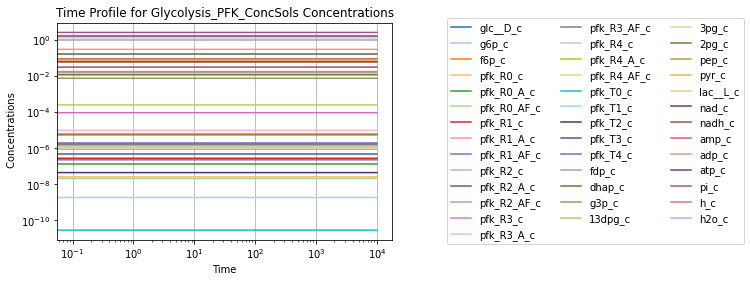

In [19]:
sim_PFK = Simulation(glycolysis_PFK)

t0, tf = (0, 1e4)
sim_PFK.find_steady_state(
    glycolysis_PFK, strategy="simulate", update_values=True,
    tfinal=1e5, steps=1e5)

conc_sol_ss, flux_sol_ss = sim_PFK.simulate(
    glycolysis_PFK, time=(t0, tf, tf*10 + 1))
conc_sol_ss.view_time_profile()

### Response to an increased $k_{ATPM}$
We now perturb the integrated model by increasing the rate of ATP utilization as in Chapters 10. We show the results in the form of the same key flux phase portraits.

In [20]:
conc_sol, flux_sol = sim_PFK.simulate(
    glycolysis_PFK, time=(t0, tf, tf * 10 + 1),
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"})

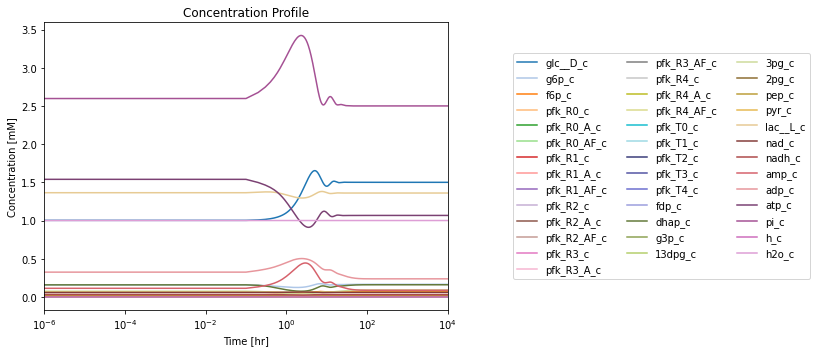

In [21]:
fig_14_4, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5));

plot_time_profile(
    conc_sol, ax=ax, legend="right outside", 
    plot_function="semilogx", xlim=(1e-6, tf),
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));
fig_14_4.tight_layout()

**Figure 14.4:** Simulating the combined system from the steady state with 50% increase in the rate of ATP utilization at $t = 0.$*

#### The proton node
The proton node has a connectivity of 12 with 9 production reactions and 3 utilization reactions. 

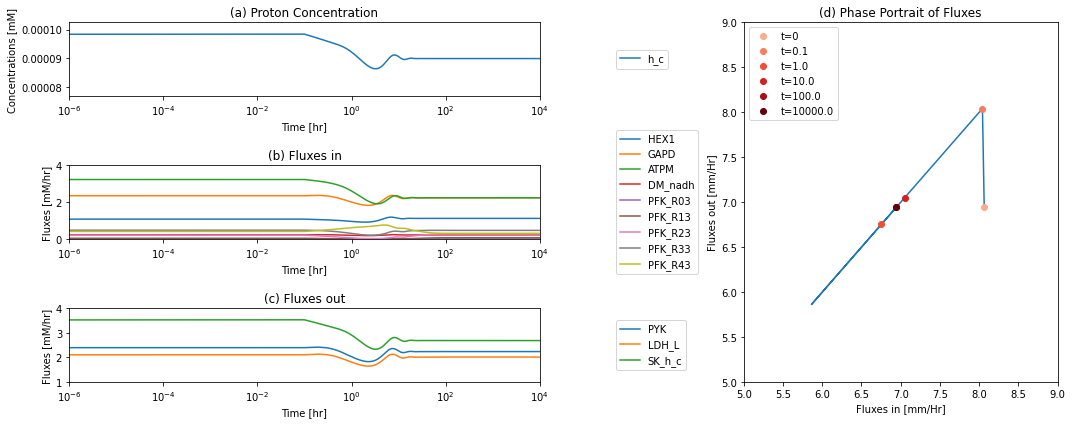

In [22]:
fig_14_5 = plt.figure(figsize=(15, 6))
gs = fig_14_5.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_14_5.add_subplot(gs[0, 0])
ax2 = fig_14_5.add_subplot(gs[1, 0])
ax3 = fig_14_5.add_subplot(gs[2, 0])
ax4 = fig_14_5.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="h_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(7.7e-5, 1e-4*1.025),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["HEX1", "GAPD", "ATPM", "DM_nadh", 
             "PFK_R03", "PFK_R13", "PFK_R23", "PFK_R33", "PFK_R43"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(0, 4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["PYK", "LDH_L", "SK_h_c"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(1, 4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(5, 9), ylim=(5, 9),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");
fig_14_5.tight_layout()

**Figure 14.5:**	The time profiles of the (a) proton concentration, (b) the fluxes that make protons, (c) the fluxes that use protons and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales).

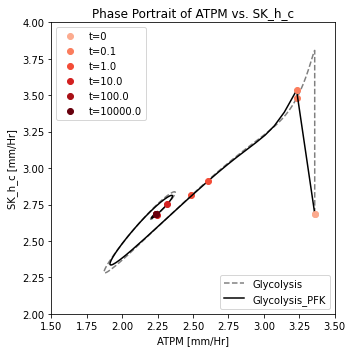

In [23]:
sim_glycolysis = Simulation(glycolysis)
sim_glycolysis.simulate(
    glycolysis, time=(t0, tf),
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"});

linestyles = ["--", "-"]
colors = ["grey", "black"]

fig_14_6, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

for i, (model, sim) in enumerate(zip([glycolysis, glycolysis_PFK],
                                     [sim_glycolysis, sim_PFK])):
    flux_solution = sim.flux_solutions.get_by_id(
        "_".join((model.id, "FluxSols")))
    plot_phase_portrait(
        flux_solution, x="ATPM", y="SK_h_c", ax=ax,
        legend=(model.id, "lower right"),
        xlabel="ATPM [mm/Hr]", ylabel="SK_h_c [mm/Hr]",
        xlim=(1.5, 3.5), ylim=(2, 4),
        title=("Phase Portrait of ATPM vs. SK_h_c", L_FONT),
        color=colors[i], linestyle=linestyles[i],
        annotate_time_points=time_points,
        annotate_time_points_color=time_point_colors,
        annotate_time_points_legend="best")
fig_14_6.tight_layout()

**Figure 14.6:** A phase portrait of the instantly imbalanced ATP demand flux and the proton exchange rate with (solid line) and without (dashed line) coupling of the PFK sub-network to the glycolytic network.

#### Key fluxes and pairwise phase portraits
Here we examine the key fluxes through the PFK enzyme and in the integrated model. 

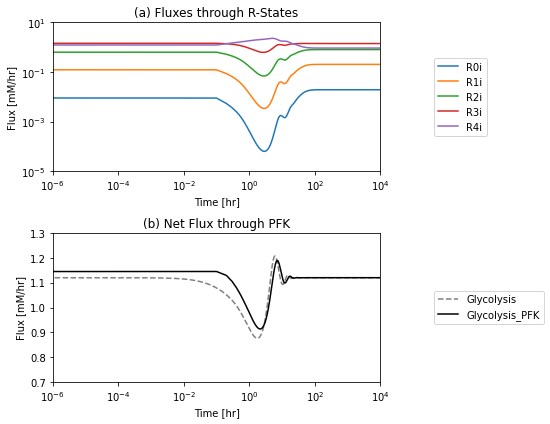

In [24]:
PFK_module = glycolysis_PFK.enzyme_modules.PFK

# Create equations for flux through various enzyme module forms groups
equations_dict = {}
for i in range(0, 5):
    PFK_rxns = ["PFK_R{0:d}{1:d}".format(i, j) for j in range(1, 4)]
    equations_dict["R{0:d}i".format(i)] = [" + ".join(PFK_rxns),
                                           PFK_rxns]
# Obtain reactions responsible for catalysis
catalyzation_rxns = PFK_module.enzyme_module_reactions_categorized.get_by_id("catalyzation")
catalyzation_rxns = [m.id for m in catalyzation_rxns.members]

# Create equation for net flux through enzyme
equations_dict["PFK"] = [" + ".join(catalyzation_rxns),
                         catalyzation_rxns]

# Create flux solutions for equations
for flux_id, (equation, variables) in equations_dict.items():
    flux_sol.make_aggregate_solution(
        flux_id, equation=equation, variables=variables)

fig_14_7, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    flux_sol, observable=list(equations_dict)[:-1], ax=ax1, 
    legend="right outside", plot_function="loglog",
    xlim=(1e-6, tf), ylim=(1e-5, 1e1),
    xlabel="Time [hr]", ylabel="Flux [mM/hr]",
    title=("(a) Fluxes through R-States", L_FONT));

for i, (model, sim) in enumerate(zip([glycolysis, glycolysis_PFK],
                                     [sim_glycolysis, sim_PFK])):
    flux_solution = sim.flux_solutions.get_by_id(
        "_".join((model.id, "FluxSols")))
    
    plot_time_profile(
        flux_solution, observable="PFK", ax=ax2,
        legend=[model.id, "right outside"], plot_function="semilogx", 
        xlim=(1e-6, tf), ylim=(.7, 1.3),
        xlabel="Time [hr]", ylabel="Flux [mM/hr]",
        color=colors[i], linestyle=linestyles[i],
        title=("(b) Net Flux through PFK", L_FONT));
fig_14_7.tight_layout()

**Figure 14.7:** (a): The individual fluxes through the R-forms of the PFK enzyme and (b) the PFK flux from the module. The new PFK flux is the sum of all fluxes through the R-forms. The dashed line is the PFK flux in the glycolytic model without the coupling of the PFK sub-network*

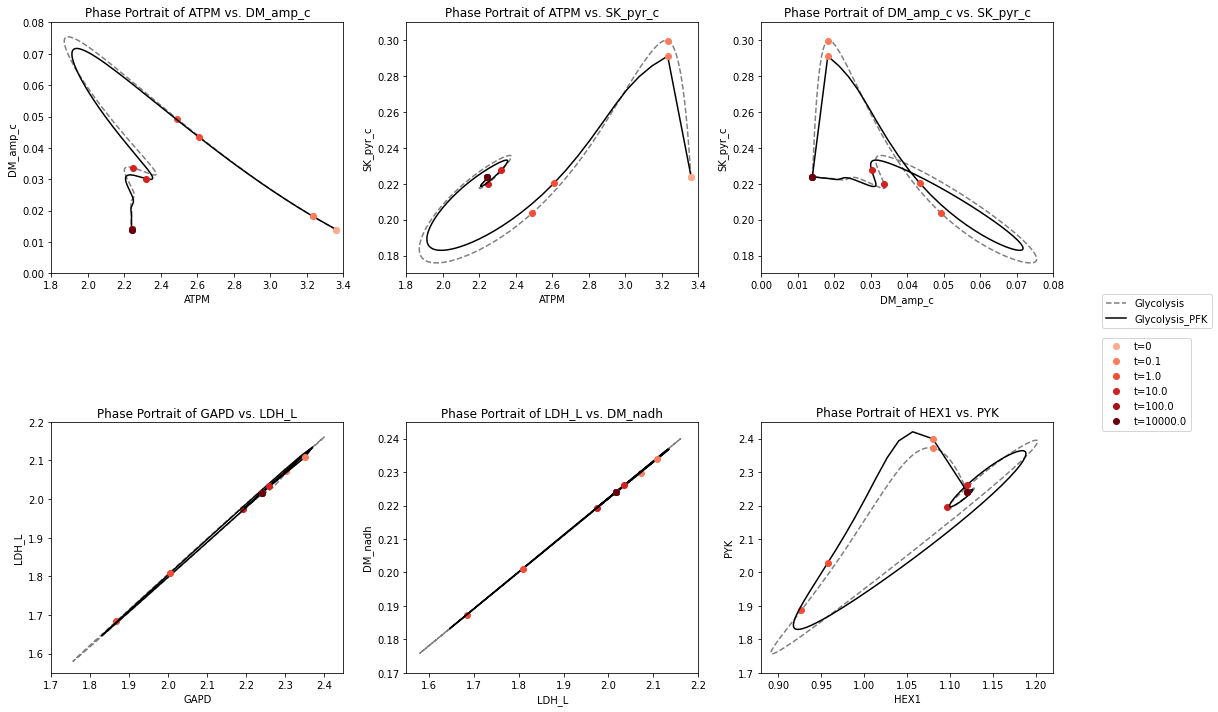

In [25]:
fig_14_8, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 10))
axes = axes.flatten()

time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

pairings = [
    ("ATPM", "DM_amp_c"), ("ATPM", "SK_pyr_c"), ("DM_amp_c", "SK_pyr_c"), 
    ("GAPD", "LDH_L"), ("LDH_L", "DM_nadh"), ("HEX1", "PYK")]
xlims = [
    (1.80, 3.40), (1.80, 3.40), (0.00, 0.08),
    (1.70, 2.45), (1.55, 2.200), (0.88, 1.22)]
ylims = [
    (0.00, 0.08), (0.17, 0.31), (0.17, 0.31),
    (1.55, 2.20), (0.17, 0.245), (1.70, 2.45)]

linestyles = ["--", "-"]
colors = ["grey", "black"]

for j, (model, sim) in enumerate(zip([glycolysis, glycolysis_PFK],
                                [sim_glycolysis, sim_PFK])):
    flux_sol = sim.flux_solutions.get_by_id(
        "_".join((model.id, "FluxSols")))
    for i, ax in enumerate(axes):
        x_i, y_i = pairings[i]
        # Create legends
        legend = None
        time_points_legend = None
        if i == 2:
            legend = [model.id, "lower right outside"]
        if i == len(axes) - 1:
            time_points_legend = "upper right outside"
            
            
        plot_phase_portrait(
            flux_sol, x=x_i, y=y_i, ax=ax, legend=legend,
            xlabel=x_i, ylabel=y_i, 
            xlim=xlims[i], ylim=ylims[i],
            title=("Phase Portrait of {0} vs. {1}".format(
                x_i, y_i), L_FONT),
            color=colors[j], linestyle=linestyles[j],
            annotate_time_points=time_points,
            annotate_time_points_color=time_point_colors,
            annotate_time_points_legend=time_points_legend)
fig_14_8.tight_layout()

**Figure 14.8:** The dynamic response of key fluxes in glycolysis. Detailed pairwise phase portraits: (a): $v_{ATPM}\ \textit{vs.}\ v_{SK_{PYR}}$. (b): $v_{GAPD}\ \textit{vs.}\ v_{LDH_{L}}$. (c): $v_{LDH_{L}}\ \textit{vs.}\ v_{DM_{NADH}}$. (d): $v_{HEX1}\ \textit{vs.}\ v_{PYK}$ Each panel compares the solution with (solid line) and without (dashed line) coupling of the PFK sub-network to the glycolytic network. The unregulated responses can be seen in in Figure 10.15. The fluxes are in units of mM/h. The perturbation is reflected in the instantaneous move of the flux state from the initial steady state to an unsteady state, as indicated by the arrow placing the initial point at $t = 0^+$. The system then returns to its steady state at $t \rightarrow \infty$.

### Ratios:
#### Increase in the rate of ATP use
The overall dynamic responses to this 50% increase in ATP utilization rate is similar with and without regulation of PFK. The enzyme in the steady state is slightly below 90% in the R form. Thus, there is little room for regulation to change. In Figure 14.9, we show the fraction of PFK in the R state versus the energy charge the response of the integrated system. The initial response to the drop in the energy charge, that results from the increased ATP usage rate, leads to an increase in PFK that is in the R state. The fraction $r_{\mathrm{R}}$ reaches almost unity, which represents the full possible regulatory response. After the response dies down, the energy charge returns to a value close to the initial one, but the fraction of PFK in the R state, $r_{\mathrm{R}}$ settles down at about 97%, slightly above where it was before. 

#### Decrease in the rate of ATP use
The regulatory action of PFK in this steady state to an increase energy usage is thus limited. To illustrate the non-linear nature of enzyme regulation, we now simulate the response of the integrated network to a drop 15% in the rate of use of ATP. The response is quite asymmetric to the response to an increase in ATP usage rate, Figure 14.9. The build up of ATP that results from the initial drop in its rate of usage rapidly inhibits PFK and the R fraction, $r_{\mathrm{R}}$, drops to about 40%. As the network then approaches its eventual steady state the ATP concentration drops, with $r_{\mathrm{R}}$ returning to about 85% and the energy charge settling at a level that that is higher than the initial point.

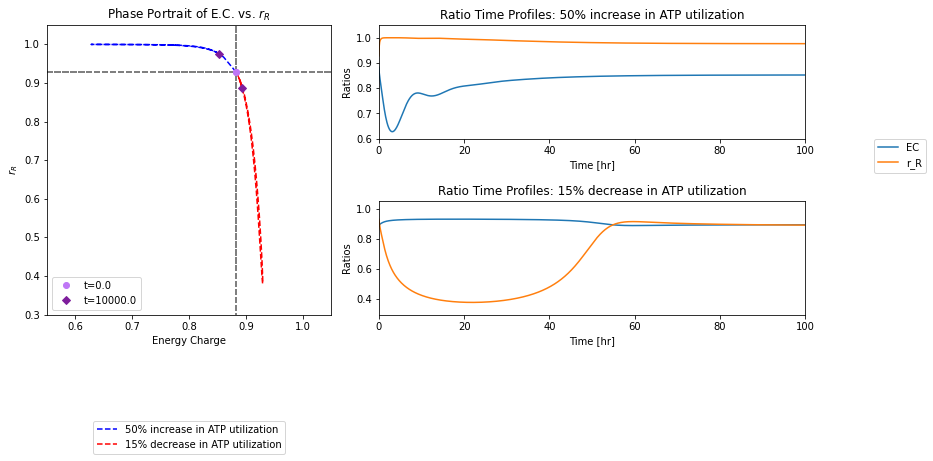

In [26]:
fig_14_9 = plt.figure(figsize=(13, 5))
gs = fig_14_9.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1.5])

ax1 = fig_14_9.add_subplot(gs[:, 0])
ax2 = fig_14_9.add_subplot(gs[0, 1])
ax3 = fig_14_9.add_subplot(gs[1, 1])

# Create pool for relaxed enzyme fraction (active fraction) and energy charge
relaxed_fraction = PFK.make_enzyme_fraction(
    "forms", top="Relaxed", bottom="Equation")
relaxed_fraction = str(strip_time(relaxed_fraction))

equations_dict = {}
equations_dict["r_R"] = [relaxed_fraction,
                         [m.id for m in PFK_module.enzyme_module_forms]]
equations_dict["EC"] = ["(2*atp_c + adp_c)/(2*(atp_c + adp_c + amp_c))",
                        ["atp_c", "adp_c", "amp_c"]]
# Create pooled solutions for equations
for pool_id, (equation, variables) in equations_dict.items():
    conc_sol_ss.make_aggregate_solution(
        pool_id, equation=equation, variables=variables)

ax1.plot([conc_sol_ss["EC"]]*2, [0, 1.05], color="grey", linestyle="--")
ax1.plot([0, 1.05], [conc_sol_ss["r_R"]]*2, color="grey", linestyle="--")

colors = ["blue", "red"]
ylims = [(0.6, 1.05), (0.3, 1.05)]

perturbations = dict(zip(
    ["50% increase in ATP utilization", "15% decrease in ATP utilization"],
    [{"kf_ATPM": "kf_ATPM * 1.5"}, {"kf_ATPM": "kf_ATPM * 0.85"}]))
for i, (perturb_type, perturb_dict) in enumerate(perturbations.items()):
    conc_sol, flux_sol = sim_PFK.simulate(
        glycolysis_PFK, time=(t0, tf, tf * 10 + 1),
        perturbations=perturb_dict)
    
    # Create pooled solutions for equations
    for pool_id, (equation, variables) in equations_dict.items():
        conc_sol.make_aggregate_solution(
            pool_id, equation=equation, variables=variables)

    plot_phase_portrait(
        conc_sol, x="EC", y="r_R", ax=ax1,
        legend=[perturb_type, "lower outside"], 
        color=colors[i], linestyle="--",
        xlabel="Energy Charge", ylabel="$r_R$",
        xlim=(0.55, 1.05), ylim=(0.3, 1.05),
        title=("Phase Portrait of E.C. vs. $r_R$", L_FONT),
        annotate_time_points="endpoints",
        annotate_time_points_color=["xkcd:light purple",
                                    "xkcd:purple"],
        annotate_time_points_legend="lower left")
    
    if i == 0:
        ax = ax2
        legend = "lower right outside"
    else:
        ax = ax3
        legend = None
    
    plot_time_profile(
        conc_sol, ax=ax, observable=["EC", "r_R"], legend=legend, 
        xlabel="Time [hr]", ylabel="Ratios", 
        xlim=(t0, 100), ylim=ylims[i],
        title=("Ratio Time Profiles: " + perturb_type, L_FONT));
fig_14_9.tight_layout()

**Figure 14.9:** The dynamic response of key ratios. (a): The phase portrait for the energy charge versus $r_{\mathrm{R}}$ for a change in ATP utilization rate $(k_{ATPM})$ where blue represents a 50% increase in ATP utilization and red represents a decrease 15% decrease in ATP utilization. (b): Time profile for the $r_{\mathrm{R}}$ and energy charge for an increase in ATP utilization. (c): Time profile for the $r_{\mathrm{R}}$ and energy charge for an decrease in ATP utilization*

## Integration of PFK with RBC Metabolic Network
The PFK subnetwork can be integrated with the core network model of chapter 13. The integration process is straight forward. Though simulation we can compare the networks with and without the PFK subnetwork. The integration is performed as:

In [27]:
# Create RBC model
glycolysis = create_example_model("SB2_Glycolysis")
ppp = create_example_model("SB2_PentosePhosphatePathway")
ampsn = create_example_model("SB2_AMPSalvageNetwork")
hemoglobin = create_example_model("SB2_Hemoglobin")

RBC_PFK = glycolysis.merge(ppp, inplace=False)
RBC_PFK.merge(ampsn, inplace=True)
RBC_PFK.remove_reactions([
    r for r in RBC_PFK.boundary
    if r.id in [
        "SK_g6p_c", "DM_f6p_c", "DM_g3p_c",
        "DM_r5p_c", "DM_amp_c", "SK_amp_c"]])
RBC_PFK.remove_boundary_conditions([
    "g6p_b", "f6p_b", "g3p_b", "r5p_b", "amp_b"])

RBC_PFK.reactions.PRPPS.subtract_metabolites({
    RBC_PFK.metabolites.atp_c: -1,
    RBC_PFK.metabolites.adp_c: 2})
RBC_PFK.reactions.PRPPS.add_metabolites({
    RBC_PFK.metabolites.amp_c: 1})
RBC_PFK.merge(hemoglobin, inplace=True)
RBC_PFK.id = "RBC"

# Load PFK module
PFK = create_example_model("SB2_PFK")
# Update the module with the parameters determined in section 14.2. 

# Add PFK module to system
RBC_PFK = RBC_PFK.merge(PFK, inplace=False)
# Delete old PFK reaction
RBC_PFK.remove_reactions([RBC_PFK.reactions.PFK])

Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.
Ignoring reaction 'ATPM' since it already exists.
Ignoring reaction 'SK_amp_c' since it already exists.
Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.


This results in an integrated network whose stoichiometric matrix is of dimensions 68 x 76 and of rank 63 

In [28]:
# Define new order for metabolites
new_metabolite_order = [
    "glc__D_c", "g6p_c", "f6p_c", "pfk_R0_c", "pfk_R0_A_c", "pfk_R0_AF_c", "pfk_R1_c", "pfk_R1_A_c", "pfk_R1_AF_c",  
    "pfk_R2_c", "pfk_R2_A_c", "pfk_R2_AF_c", "pfk_R3_c", "pfk_R3_A_c", "pfk_R3_AF_c","pfk_R4_c", "pfk_R4_A_c", 
    "pfk_R4_AF_c", "pfk_T0_c","pfk_T1_c", "pfk_T2_c", "pfk_T3_c", "pfk_T4_c", "fdp_c", "dhap_c", "g3p_c", 
    "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", "pyr_c", "lac__L_c", "_6pgl_c", "_6pgc_c", "ru5p__D_c", "xu5p__D_c", 
    "r5p_c", "s7p_c", "e4p_c", "ade_c", "adn_c", "imp_c", "ins_c", "hxan_c", "r1p_c", "prpp_c", "_23dpg_c","hb_c", 
    "hb_1o2_c", "hb_2o2_c", "hb_3o2_c", "hb_4o2_c", "dhb_c", "nad_c", "nadh_c", "amp_c", "adp_c", "atp_c", 
    "nadp_c", "nadph_c", "gthrd_c", "gthox_c", "pi_c", "h_c", "h2o_c", "co2_c", "nh3_c", "o2_c"]

if len(RBC_PFK.metabolites) == len(new_metabolite_order):
    RBC_PFK.metabolites = DictList(RBC_PFK.metabolites.get_by_any(new_metabolite_order))
# Define new order for reactions
new_reaction_order = [
    "HEX1", "PGI", "PFK_R01", "PFK_R02", "PFK_R03", "PFK_R11", "PFK_R12", "PFK_R13", "PFK_R21", "PFK_R22", "PFK_R23",
    "PFK_R31", "PFK_R32", "PFK_R33","PFK_R41", "PFK_R42", "PFK_R43", "PFK_R10", "PFK_R20", "PFK_R30","PFK_R40", 
    "PFK_T1", "PFK_T2", "PFK_T3", "PFK_T4", "PFK_L", "FBA", "TPI", "GAPD", "PGK", "PGM", "ENO", "PYK", "LDH_L", 
    "G6PDH2r", "PGL", "GND", "RPE", "RPI", "TKT1", "TKT2", "TALA", "ADNK1", "NTD7", "ADA","AMPDA", "NTD11", "PUNP5", 
    "PPM", "PRPPS", "ADPT", "ADK1", "DPGM", "DPGase", "HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ATPM", "DM_nadh", 
    "GTHOr", "GSHR", "SK_glc__D_c", "SK_pyr_c", "SK_lac__L_c", "SK_ade_c", "SK_adn_c", "SK_ins_c", "SK_hxan_c",
    "SK_pi_c", "SK_h_c", "SK_h2o_c", "SK_co2_c", "SK_nh3_c", "SK_o2_c"]
if len(RBC_PFK.reactions) == len(new_reaction_order):
    RBC_PFK.reactions = DictList(RBC_PFK.reactions.get_by_any(new_reaction_order))
RBC_PFK.update_S(array_type="DataFrame", dtype=np.int64);

,HEX1,PGI,PFK_R01,PFK_R02,PFK_R03,PFK_R11,PFK_R12,PFK_R13,PFK_R21,PFK_R22,PFK_R23,PFK_R31,PFK_R32,PFK_R33,PFK_R41,PFK_R42,PFK_R43,PFK_R10,PFK_R20,PFK_R30,PFK_R40,PFK_T1,PFK_T2,PFK_T3,PFK_T4,PFK_L,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,G6PDH2r,PGL,GND,RPE,RPI,TKT1,TKT2,TALA,ADNK1,NTD7,ADA,AMPDA,NTD11,PUNP5,PPM,PRPPS,ADPT,ADK1,DPGM,DPGase,HBDPG,HBO1,HBO2,HBO3,HBO4,ATPM,DM_nadh,GTHOr,GSHR,SK_glc__D_c,SK_pyr_c,SK_lac__L_c,SK_ade_c,SK_adn_c,SK_ins_c,SK_hxan_c,SK_pi_c,SK_h_c,SK_h2o_c,SK_co2_c,SK_nh3_c,SK_o2_c
glc__D_c,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
f6p_c,0,1,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R0_c,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R0_A_c,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R0_AF_c,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R1_c,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R1_A_c,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R1_AF_c,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
pfk_R2_c,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### The stoichiometric matrix: PFK with RBC metabolic network
The properties of the stoichiometric matrix are shown in Table 14.5. All the reactions are elementally balanced except for the exchange reactions. The matrix has dimensions of 68 x 76 and a rank of 63  It thus has a 13 dimensional null space and a five dimensional left null space. 

**Table 14.5:** The stoichiometric matrix for glycolysis, pentose phosphate pathway, AMP degradation and biosynthetic pathways, the Rapoport-Luebering (R.L.) shunt, the binding states of hemoglobin, and the PFK enzyme.

In [29]:
# Define labels
metabolite_ids = [m.id for m in RBC_PFK.metabolites]
reaction_ids = [r.id for r in RBC_PFK.reactions]

pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', '[PFK]', '[HB]', '[NAD]', '[NADP]']
time_inv_labels = ["$N_{\mathrm{tot}}$", "$NP_{\mathrm{tot}}$", "$G_{\mathrm{tot}}$", 
                   "$Hb_{\mathrm{tot}}$", "$PFK_{\mathrm{tot}}$"]
path_labels = ["$p_1$", "$p_2$", "$p_3$", "$p_4$", "$p_5$", 
               "$p_6$", "$p_7$", "$p_8$", "$p_9$", "$p_{10}$", 
               "$p_{11}$", "$p_{12}$", "$p_{13}$"]

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = RBC_PFK.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = RBC_PFK.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 1, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0],
    [1,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 1, 0, 1, 0, 0, 0, 0, 0,13,-3, 3, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 1, 0, 0, 0, 4, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-3, 0, 2, 2, 1, 0, 0,-1, 0, 1, 0, 0, 4,-1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,-1, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
])
table_14_5 = np.vstack((S_matrix, pi, ES_matrix, minspan_paths))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_14_5) - len(metabolite_ids))
rho = np.concatenate((rho, blanks))

lns = np.zeros((5, 68), dtype=np.int64)
lns[0][53:55] = 1
lns[1][58:60] = 1
lns[2][60] = 1
lns[2][61] = 2
lns[3][47:53] = 1
lns[4][3:23] = 1

time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_14_5 = np.vstack([table_14_5.T, rho, time_inv]).T

colors = {"glycolysis": "#ffffe6",    # Yellow
          "ppp": "#e6faff",           # Light blue
          "ampsn": "#d9fad2",
          "hemoglobin": "#ffcccc",
          "pfk": "#F4D03F",
          "cofactor": "#ffe6cc",
          "inorganic": "#fadffa",
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
cofactor_mets = ["nad_c", "nadh_c",  "amp_c", "adp_c", "atp_c", 
                 "nadp_c", "nadph_c", "gthrd_c", "gthox_c"]
exch_misc_rxns= ["SK_glc__D_c", "SK_pyr_c", "SK_lac__L_c", "SK_ade_c", "SK_adn_c",
                 "SK_ins_c", "SK_hxan_c", "ATPM", "DM_nadh", "GTHOr", "GSHR"]
inorganic_mets = ["pi_c", "h_c", "h2o_c", "co2_c", "nh3_c", "o2_c"]
inorganic_exch = ["SK_pi_c", "SK_h_c", "SK_h2o_c", "SK_co2_c", "SK_nh3_c", "SK_o2_c"]

def highlight_table(df, model):
    df = df.copy() 
    condition = lambda mmodel, row, col, c1, c2:  (
        (col not in exch_misc_rxns + inorganic_exch) and (row not in cofactor_mets + inorganic_mets) and (
            (row in mmodel.metabolites and c1) or (col in mmodel.reactions or c2)))
    inorganic_condition = lambda row, col: (col in inorganic_exch or row in inorganic_mets)
    for i, row in enumerate(df.index):
        for j, col in enumerate(df.columns):
            if df.loc[row, col] == "":
                main_key = "blank"
            elif row in pi_str:
                main_key = "pi"
            elif row in chopsnq:
                main_key = "chopsnq"
            elif row in path_labels:
                main_key = "pathways"
            elif col in rho_str:
                main_key = "rho"
            elif col in time_inv_labels:
                main_key = "time_invs"
            elif condition(hemoglobin, row, col, row not in ["_13dpg_c", "_3pg_c"], False):
                main_key = "hemoglobin"
            elif condition(ampsn, row, col, row not in ["r5p_c"], col in ["ADK1"]):
                main_key = "ampsn"
            elif condition(ppp, row, col, row not in ["g6p_c", "f6p_c", "g3p_c"], False):
                main_key = "ppp"
            elif condition(glycolysis, row, col, True, False):
                main_key = "glycolysis"
            elif condition(PFK, row, col, True, False):
                main_key = "pfk"
            elif ((col in exch_misc_rxns or row in cofactor_mets) and not inorganic_condition(row, col)):
                main_key = "cofactor"
            elif inorganic_condition(row, col):
                main_key = "inorganic"
            else:
                continue
            df.loc[row, col] = bg_color_str + colors[main_key]  
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_14_5 = pd.DataFrame(
    table_14_5, index=index_labels, columns=column_labels)
# Apply colors
table_14_5 = table_14_5.style.apply(
    highlight_table,  model=RBC_PFK, axis=None)
table_14_5

### The null spaces: PFK with RBC metabolic network
The null space is thus 13 (=76-63) dimensional. It fundamentally has the same pathways as the previous models alone. The difference is that pathway 1 in Figure 10.2  now becomes five pathways $(\textbf{p}_1$ through $\textbf{p}_5$ in Table 14.4), one through each of the $R_i$ forms of PFK, consistent with the properties of the stoichiometric matrix for the PFK subnetwork. The remaining pathways are the same as the ones seen in previous models and become $\textbf{p}_6$ through $\textbf{p}_{13}$ in Table 14.4 to make a total of 13 pathways. 

The left null space is 5 (=68-63) dimensional. It has the same pools as the previous models, namely the total phosphate pool, NAD and NADP pools, the total hemoglobin pool,and the total PFK pool that originates from the stoichiometric matrix of the PFK subnetwork, Table 14.2.

## Simulating the RBC Metabolic Network with PFK
### Defining the Steady State 

We start by ensuring our model is at steady state. 

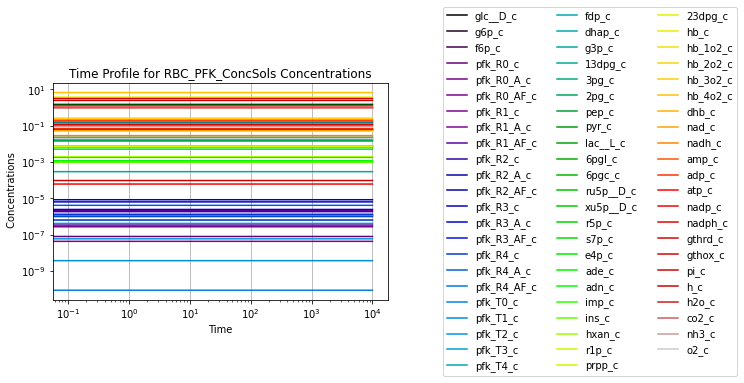

In [30]:
sim_RBC_PFK = Simulation(RBC_PFK)
sim_RBC_PFK.find_steady_state(
    RBC_PFK, strategy="simulate", update_values=True);

t0, tf = (0, 1e4)
conc_sol_ss, flux_sol_ss = sim_RBC_PFK.simulate(
    RBC_PFK, time=(t0, tf, tf*10 + 1))
conc_sol_ss.view_time_profile()

### Response to an increased $k_{ATPM}$: PFK with RBC metabolic network
We now perturb the integrated model by increasing the rate of ATP utilization by 25%. Note that the perturbation is smaller than in previous chapters to allow for a steady state to be reached, even with the additional regulatory mechanisms in the larger RBC model.

In [31]:
t0, tf = (0, 1e4)
conc_sol, flux_sol = sim_RBC_PFK.simulate(
    RBC_PFK, time=(t0, tf, tf*10 + 1),
    perturbations={"kf_ATPM": "kf_ATPM * 1.25"});

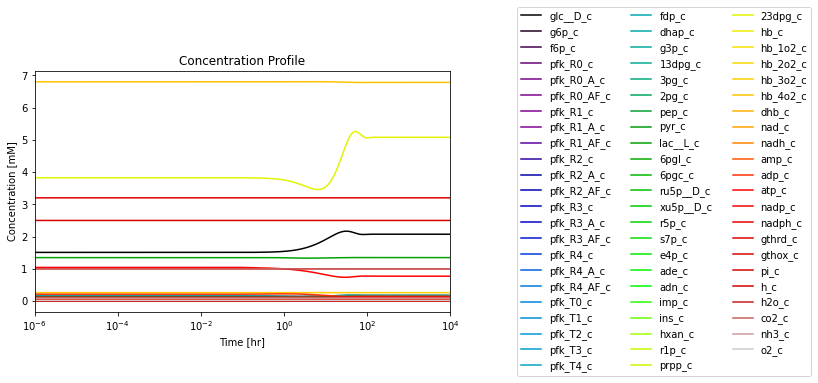

In [32]:
fig_14_11, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5));

plot_time_profile(
    conc_sol, ax=ax, legend="right outside", 
    plot_function="semilogx", xlim=(1e-6, tf),
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));
fig_14_11.tight_layout()

**Figure 14.11:** Simulating the combined system from the steady state with 25% increase in the rate of ATP utilization at $t = 0.$*

#### The proton node: PFK with RBC metabolic network
The proton node now has a connectivity of 20 with 16 production reactions and 4 utilization reactions. 

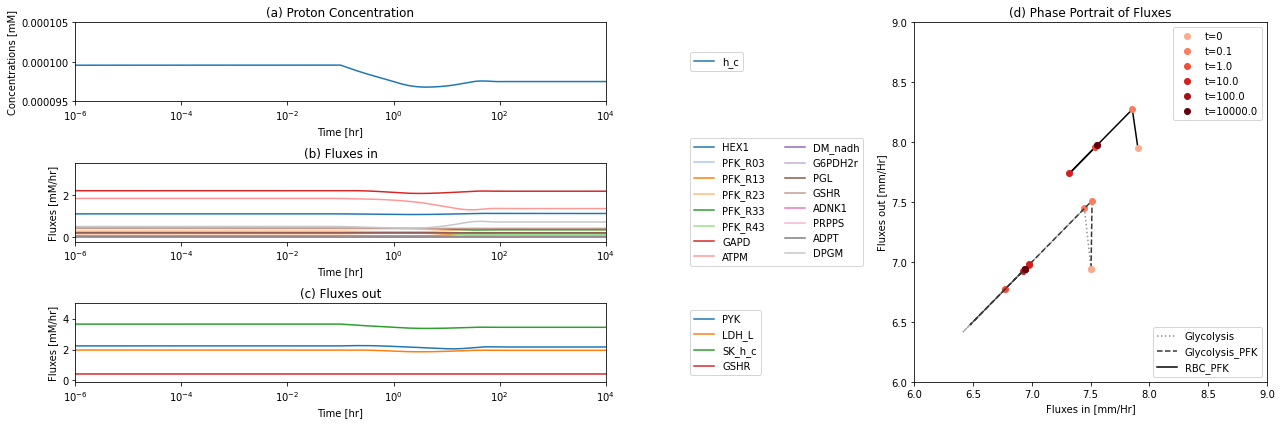

In [33]:
fig_14_12 = plt.figure(figsize=(18, 6))
gs = fig_14_12.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_14_12.add_subplot(gs[0, 0])
ax2 = fig_14_12.add_subplot(gs[1, 0])
ax3 = fig_14_12.add_subplot(gs[2, 0])
ax4 = fig_14_12.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="h_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(1e-4 - 5e-6, 1e-4 + 5e-6),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["HEX1", "PFK_R03", "PFK_R13", "PFK_R23", "PFK_R33", "PFK_R43",
             "GAPD", "ATPM", "DM_nadh", "G6PDH2r", "PGL", 
             "GSHR", "ADNK1", "PRPPS", "ADPT", "DPGM"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(-0.2, 3.5),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));


fluxes_out = ["PYK", "LDH_L", "SK_h_c", "GSHR"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(-.1, 5), 
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

linestyles = [":", "--", "-"]
colors = ["xkcd:grey", "xkcd:dark grey", "black"]

for i, model, in enumerate([glycolysis, glycolysis_PFK, RBC_PFK]):
    sim = Simulation(model)
    flux_solution = sim.simulate(
        model, time=(t0, tf, tf*10 + 1),
        perturbations={"kf_ATPM": "kf_ATPM * 1.25"})[1]
    
    model_fluxes_in = [r for r in fluxes_in if r in model.reactions]
    if model.id == "Glycolysis":
        model_fluxes_in += ["PFK"]
    model_fluxes_out = [r for r in fluxes_out if r in model.reactions]
    
    for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                                  [model_fluxes_in, model_fluxes_out]):
        flux_solution.make_aggregate_solution(
            flux_id, equation=" + ".join(variables), variables=variables)
    
    plot_phase_portrait(
        flux_solution, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
        legend=[model.id, "lower right"],
        xlim=(6, 9), ylim=(6, 9),
        xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
        title=("(d) Phase Portrait of Fluxes", L_FONT),
        color=colors[i], linestyle=linestyles[i],
        annotate_time_points=time_points,
        annotate_time_points_color=time_point_colors,
        annotate_time_points_legend="best");
fig_14_12.tight_layout()

**Figure 14.12:**	The time profiles of the (a) proton concentration, (b) the fluxes that make protons, (c) the fluxes that use protons and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales).

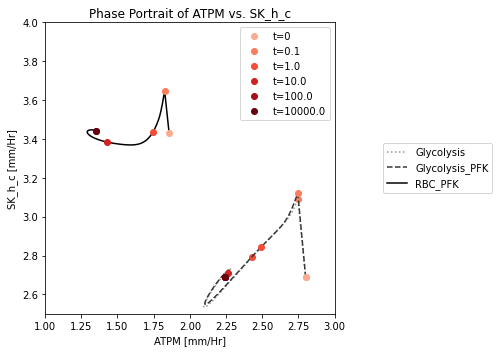

In [34]:
fig_14_13, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

for i, model, in enumerate([glycolysis, glycolysis_PFK, RBC_PFK]):
    sim = Simulation(model)
    flux_solution = sim.simulate(
        model, time=(t0, tf, tf*10 + 1),
        perturbations={"kf_ATPM": "kf_ATPM * 1.25"})[1]

    plot_phase_portrait(
        flux_solution, x="ATPM", y="SK_h_c", ax=ax,
        legend=(model.id, "right outside"),
        xlabel="ATPM [mm/Hr]", ylabel="SK_h_c [mm/Hr]",
        xlim=(1, 3.), ylim=(2.5, 4),
        title=("Phase Portrait of ATPM vs. SK_h_c", L_FONT),
        color=colors[i], linestyle=linestyles[i],
        annotate_time_points=time_points,
        annotate_time_points_color=time_point_colors,
        annotate_time_points_legend="best")
fig_14_13.tight_layout()

**Figure 14.13:** A phase portrait of the instantly imbalanced ATP demand flux and the proton exchange rate with the core network coupled to the PFK sub-network (black line), and the glycolytic network with (dark grey dashed line) and without (ligh grey dashed line) coupling of the PFK sub-network.

#### Key fluxes and pairwise phase portraits: PFK with RBC metabolic network
Here we examine the key fluxes through the PFK enzyme and in the integrated model. 

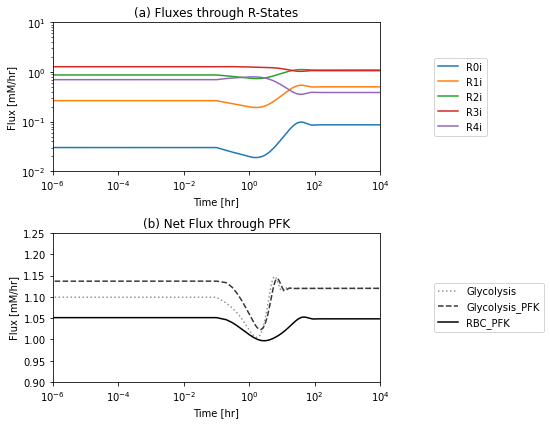

In [35]:
PFK_module = RBC_PFK.enzyme_modules.PFK

# Create equations for flux through various enzyme module form groups
equations_dict = {}
for i in range(0, 5):
    PFK_rxns = ["PFK_R{0:d}{1:d}".format(i, j) for j in range(1, 4)]
    equations_dict["R{0:d}i".format(i)] = [" + ".join(PFK_rxns),
                                           PFK_rxns]
# Obtain reactions responsible for catalysis
catalyzation_rxns = PFK_module.enzyme_module_reactions_categorized.get_by_id("catalyzation")
catalyzation_rxns = [m.id for m in catalyzation_rxns.members]

# Create equation for net flux through enzyme
equations_dict["PFK"] = [" + ".join(catalyzation_rxns),
                         catalyzation_rxns]

# Create flux solutions for equations
for flux_id, (equation, variables) in equations_dict.items():
    flux_sol.make_aggregate_solution(
        flux_id, equation=equation, variables=variables)

fig_14_14, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    flux_sol, observable=list(equations_dict)[:-1], ax=ax1, 
    legend="right outside", plot_function="loglog",
    xlim=(1e-6, tf), ylim=(1e-2, 1e1),
    xlabel="Time [hr]", ylabel="Flux [mM/hr]",
    title=("(a) Fluxes through R-States", L_FONT));

for i, model, in enumerate([glycolysis, glycolysis_PFK, RBC_PFK]):
    sim = Simulation(model)
    flux_solution = sim.simulate(
        model, time=(t0, tf, tf*10 + 1),
        perturbations={"kf_ATPM": "kf_ATPM * 1.25"})[1]
    
    if i > 0:
        # Create flux solutions for equations
        flux_solution.make_aggregate_solution(
            "PFK", equation=equations_dict["PFK"][0],
            variables=equations_dict["PFK"][1])
    
    plot_time_profile(
        flux_solution, observable="PFK", ax=ax2,
        legend=[model.id, "right outside"], plot_function="semilogx", 
        xlim=(1e-6, tf), ylim=(.9, 1.25),
        xlabel="Time [hr]", ylabel="Flux [mM/hr]",
        color=colors[i], linestyle=linestyles[i],
        title=("(b) Net Flux through PFK", L_FONT));
fig_14_14.tight_layout()

**Figure 14.14:** (a): The individual fluxes through the R-forms of the PFK enzyme and (b) the PFK flux from the module. The new PFK flux is the sum of all fluxes through the R-forms.

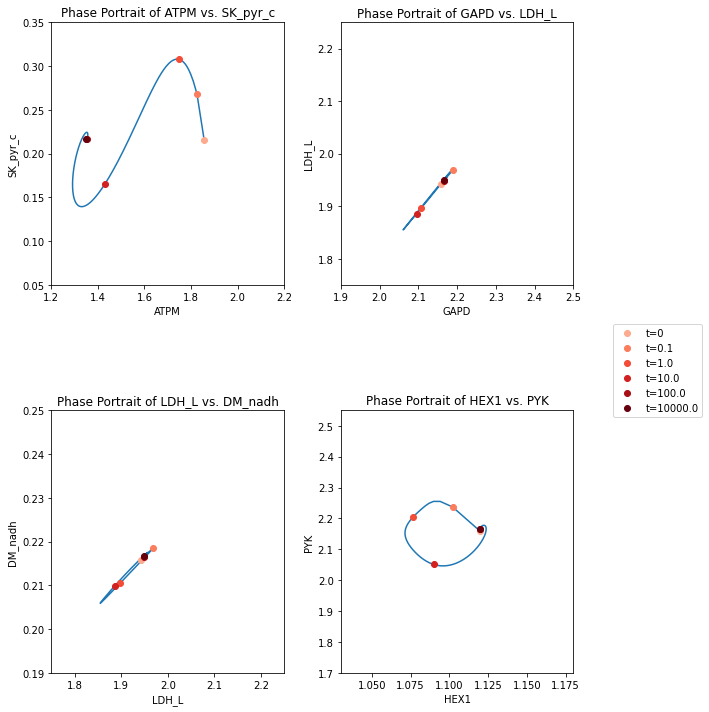

In [36]:
fig_14_15, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

pairings = [("ATPM", "SK_pyr_c"), ("GAPD", "LDH_L"), 
            ("LDH_L", "DM_nadh"), ("HEX1", "PYK")]
xlims = [(1.20, 2.20), (1.90, 2.5), (1.75, 2.25), (1.03, 1.18)]
ylims = [(0.05, 0.35), (1.75, 2.25), (.19,.25), (1.70, 2.55)]

sim = Simulation(RBC_PFK)
flux_sol = sim.simulate(
    RBC_PFK, time=(t0, tf, tf*10 + 1),
    perturbations={"kf_ATPM": "kf_ATPM * 1.25"})[1]
    
for i, ax in enumerate(axes):
    time_points_legend = None
    if i == len(axes) - 1:
        time_points_legend = "upper right outside"
    x_i, y_i = pairings[i]
    plot_phase_portrait(
        flux_sol, x=x_i, y=y_i, ax=ax, 
        xlabel=x_i, ylabel=y_i, 
        xlim=xlims[i], ylim=ylims[i],
        title=("Phase Portrait of {0} vs. {1}".format(
            x_i, y_i), L_FONT),
        annotate_time_points=time_points,
        annotate_time_points_color=time_point_colors,
        annotate_time_points_legend=time_points_legend)
fig_14_15.tight_layout()

**Figure 14.15:** The dynamic response of key fluxes in glycolysis. Detailed pairwise phase portraits: (a): $v_{ATPM}\ \textit{vs.}\ v_{SK_{PYR}}$. (b): $v_{GAPD}\ \textit{vs.}\ v_{LDH_{L}}$. (c): $v_{LDH_{L}}\ \textit{vs.}\ v_{DM_{NADH}}$. (d): $v_{HEX1}\ \textit{vs.}\ v_{PYK}$ The fluxes are in units of mM/h. The perturbation is reflected in the instantaneous move of the flux state from the initial steady state to an unsteady state, as indicated by the arrow placing the initial point at $t = 0^+$. The system then returns to its steady state at $t \rightarrow \infty$.

$\tiny{\text{© B. Ø. Palsson 2011;}\ \text{This publication is in copyright.}\\ \text{Subject to statutory exception and to the provisions of relevant collective licensing agreements,}\\ \text{no reproduction of any part may take place without the written permission of Cambridge University Press.}}$